In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, roc_auc_score, precision_recall_curve,  accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.cluster.hierarchy import dendrogram, linkage
from kmodes.kmodes import KModes
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import logging

In [6]:
# Load and prepare data
mhc_combined = pd.read_csv('mhc_combined.csv')
mhc_combined = mhc_combined.sample(frac=0.1, random_state=42)

# Target columns
target = 'DEPRESSFLG'

# Preparing feature and target sets for both DEPRESSFLG
X = mhc_combined.drop(columns=[target, target])
y = mhc_combined[target]

# Splitting data into training and testing sets for target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# print smote results
print('Original dataset shape %s' % Counter(y_train))
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0: 11327, 1: 6984})
Resampled dataset shape Counter({0: 11327, 1: 11327})


# Supervised Models

## Logistic Regression

In [3]:
# Define the Logistic Regression pipeline
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('log_reg', LogisticRegression(random_state=42))
])

# Define the Optuna objective function
def objective(trial):
    # Suggest values for hyperparameters
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear'])

    # Update the pipeline with suggested hyperparameters
    log_reg_pipeline.set_params(log_reg__C=C, log_reg__solver=solver)

    # Perform cross-validation
    cv_scores = cross_val_score(log_reg_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
    return cv_scores.mean()

In [ ]:
# Set Optuna logging level to suppress trial outputs
#optuna.logging.set_verbosity(logging.WARNING)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(study.best_params)

Best Hyperparameters:
{'C': 0.0005572088081667048, 'solver': 'liblinear'}


In [5]:
# Update the pipeline with the best hyperparameters
best_params = study.best_params
log_reg_pipeline.set_params(log_reg__C=best_params['C'], log_reg__solver=best_params['solver'])

# Retrain the model on the resampled training data
log_reg_pipeline.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred_opt = log_reg_pipeline.predict(X_test)
print("Confusion Matrix for Logistic Regression - DEPRESSFLG")
print(confusion_matrix(y_test, y_pred_opt))
print("\nClassification Report for Logistic Regression - DEPRESSFLG:")
print(classification_report(y_test, y_pred_opt))
print(f"Test Set Accuracy for Logistic Regression - DEPRESSFLG: {accuracy_score(y_test, y_pred_opt)}")

Confusion Matrix for Logistic Regression - DEPRESSFLG
[[1427 1344]
 [ 810  997]]

Classification Report for Logistic Regression - DEPRESSFLG:
              precision    recall  f1-score   support

           0       0.64      0.51      0.57      2771
           1       0.43      0.55      0.48      1807

    accuracy                           0.53      4578
   macro avg       0.53      0.53      0.53      4578
weighted avg       0.55      0.53      0.53      4578

Test Set Accuracy for Logistic Regression - DEPRESSFLG: 0.5294888597640891


## Random Forest Classifier

In [14]:
# Define Random Forest pipeline
rf_pipeline = RandomForestClassifier(random_state=42)

# Define the Optuna objective function
def objective_rf(trial):
    # Suggest hyperparameters for Random Forest
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Set the parameters for Random Forest
    rf_pipeline.set_params(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Perform cross-validation
    cv_scores = cross_val_score(rf_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
    return cv_scores.mean()

In [15]:
# Create an Optuna study for Random Forest
print("\nOptuna Tuning for Random Forest - DEPRESSFLG")
study_rf_dep = optuna.create_study(direction='maximize')
study_rf_dep.optimize(lambda trial: objective_rf(trial), n_trials=50)

# Print the best hyperparameters
print("Best parameters for Random Forest (DEPRESSFLG):", study_rf_dep.best_params)


Optuna Tuning for Random Forest - DEPRESSFLG
Best parameters for Random Forest (DEPRESSFLG): {'n_estimators': 192, 'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 1}


In [16]:
# Set the best parameters to the Random Forest pipeline
best_params_rf = study_rf_dep.best_params
rf_pipeline.set_params(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf']
)

# Train on the resampled training data
rf_pipeline.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred_rf = rf_pipeline.predict(X_test)
print("\nConfusion Matrix for Random Forest - DEPRESSFLG:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report for Random Forest - DEPRESSFLG:")
print(classification_report(y_test, y_pred_rf))
print(f"Test Set Accuracy for Random Forest: {accuracy_score(y_test, y_pred_rf)}")


Confusion Matrix for Random Forest - DEPRESSFLG:
[[1654 1117]
 [ 979  828]]

Classification Report for Random Forest - DEPRESSFLG:
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      2771
           1       0.43      0.46      0.44      1807

    accuracy                           0.54      4578
   macro avg       0.53      0.53      0.53      4578
weighted avg       0.55      0.54      0.54      4578

Test Set Accuracy for Random Forest: 0.5421581476627348


## Gradient Boosting

In [17]:
# Define Gradient Boosting pipeline
gb_pipeline = GradientBoostingClassifier(random_state=42)

# Define the Optuna objective function
def objective_gb(trial):
    # Suggest hyperparameters for Gradient Boosting
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # Set the parameters for Gradient Boosting
    gb_pipeline.set_params(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )

    # Perform cross-validation
    cv_scores = cross_val_score(gb_pipeline, X_resampled, y_resampled, cv=5, scoring='accuracy')
    return cv_scores.mean()

In [18]:
# Create an Optuna study for Gradient Boosting
print("\nOptuna Tuning for Gradient Boosting - DEPRESSFLG")
study_gb_dep = optuna.create_study(direction='maximize')
study_gb_dep.optimize(lambda trial: objective_gb(trial), n_trials=50)

# Print the best hyperparameters
print("Best parameters for Gradient Boosting (DEPRESSFLG):", study_gb_dep.best_params)


Optuna Tuning for Gradient Boosting - DEPRESSFLG
Best parameters for Gradient Boosting (DEPRESSFLG): {'n_estimators': 235, 'learning_rate': 0.05666578714521589, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 4}


In [19]:
# Set the best parameters to the Gradient Boosting pipeline
best_params_gb = study_gb_dep.best_params
gb_pipeline.set_params(
    n_estimators=best_params_gb['n_estimators'],
    learning_rate=best_params_gb['learning_rate'],
    max_depth=best_params_gb['max_depth'],
    min_samples_split=best_params_gb['min_samples_split'],
    min_samples_leaf=best_params_gb['min_samples_leaf']
)

# Train on the resampled training data
gb_pipeline.fit(X_resampled, y_resampled)

# Evaluate on the test set
y_pred_gb = gb_pipeline.predict(X_test)
print("\nConfusion Matrix for Gradient Boosting - DEPRESSFLG:")
print(confusion_matrix(y_test, y_pred_gb))
print("\nClassification Report for Gradient Boosting - DEPRESSFLG:")
print(classification_report(y_test, y_pred_gb))
print(f"Test Set Accuracy for Gradient Boosting: {accuracy_score(y_test, y_pred_gb)}")


Confusion Matrix for Gradient Boosting - DEPRESSFLG:
[[1611 1160]
 [ 966  841]]

Classification Report for Gradient Boosting - DEPRESSFLG:
              precision    recall  f1-score   support

           0       0.63      0.58      0.60      2771
           1       0.42      0.47      0.44      1807

    accuracy                           0.54      4578
   macro avg       0.52      0.52      0.52      4578
weighted avg       0.54      0.54      0.54      4578

Test Set Accuracy for Gradient Boosting: 0.5356050677151595


## Supervised Model Evaluation

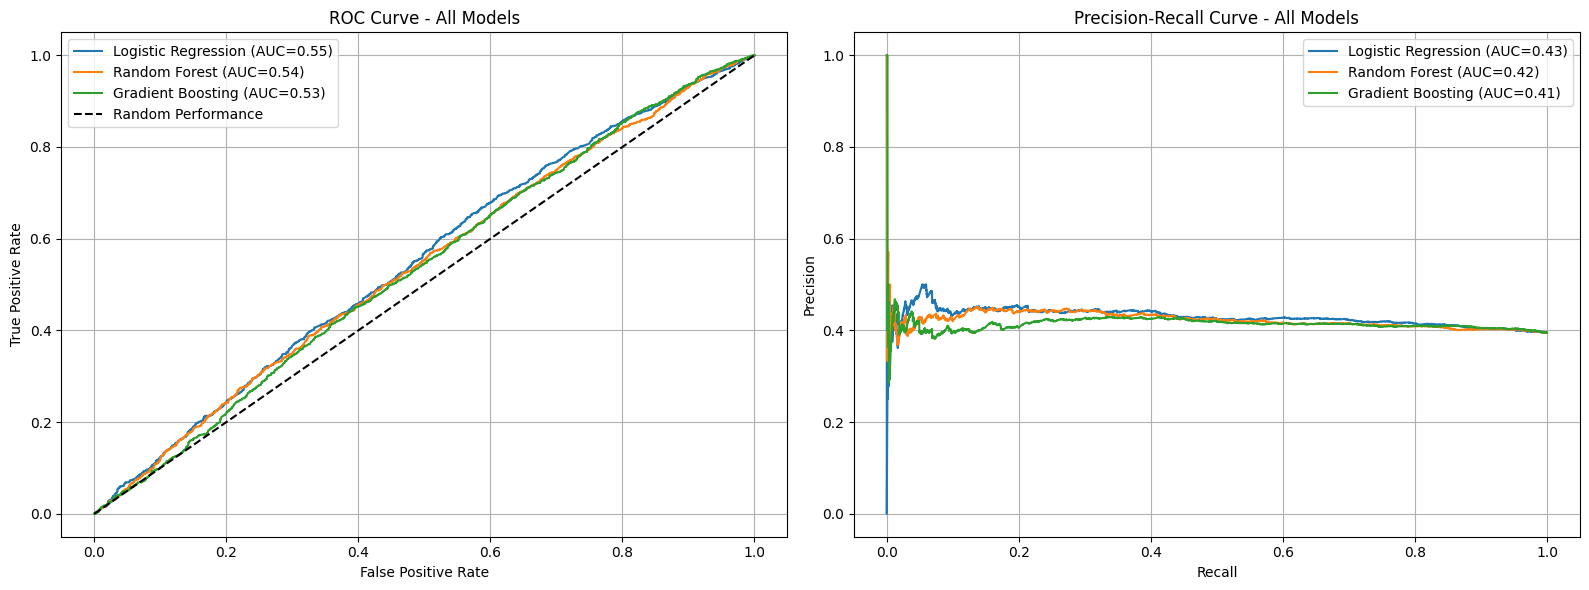

In [20]:
# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
precision_lr, recall_lr, _ = precision_recall_curve(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
roc_auc_lr = roc_auc_score(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
pr_auc_lr = auc(recall_lr, precision_lr)

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
roc_auc_rf = roc_auc_score(y_test, rf_pipeline.predict_proba(X_test)[:, 1])
pr_auc_rf = auc(recall_rf, precision_rf)

# Gradient Boosting
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_pipeline.predict_proba(X_test)[:, 1])
precision_gb, recall_gb, _ = precision_recall_curve(y_test, gb_pipeline.predict_proba(X_test)[:, 1])
roc_auc_gb = roc_auc_score(y_test, gb_pipeline.predict_proba(X_test)[:, 1])
pr_auc_gb = auc(recall_gb, precision_gb)

# 1x2 Subplot for ROC and PRC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_lr:.2f})')
axes[0].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.2f})')
axes[0].plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_gb:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Performance')  # Diagonal line
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curve - All Models')
axes[0].legend()
axes[0].grid()

# Precision-Recall Curve
axes[1].plot(recall_lr, precision_lr, label=f'Logistic Regression (AUC={pr_auc_lr:.2f})')
axes[1].plot(recall_rf, precision_rf, label=f'Random Forest (AUC={pr_auc_rf:.2f})')
axes[1].plot(recall_gb, precision_gb, label=f'Gradient Boosting (AUC={pr_auc_gb:.2f})')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve - All Models')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

Logistic Regression has best performance but is still weak

## SHAP Analysis for Logistic Regression

In [17]:
# SHAP Explainer requires a fitted model; use the logistic regression pipeline
log_reg_model = log_reg_pipeline.named_steps['log_reg']

X_sample = shap.utils.sample(X_test, 50)

# Initialize the SHAP explainer
explainer = shap.Explainer(log_reg_model, X_sample)
shap_values = explainer(X_sample)

# Initialize SHAP JavaScript visualization support
shap.initjs()

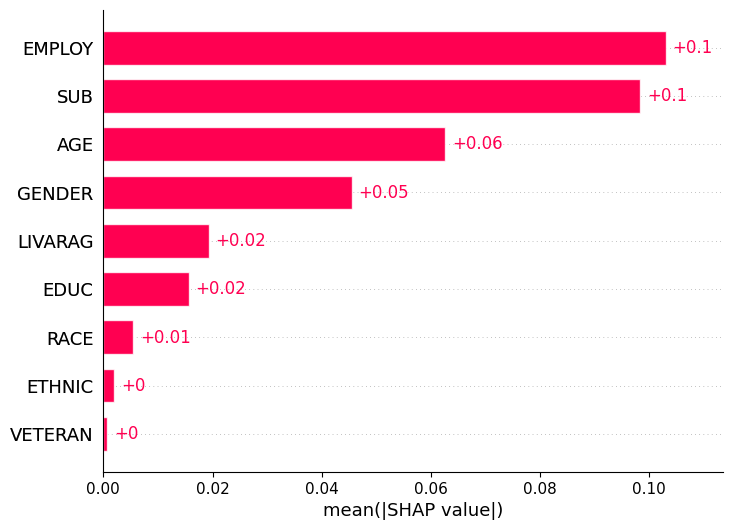

In [14]:
shap.plots.bar(shap_values)

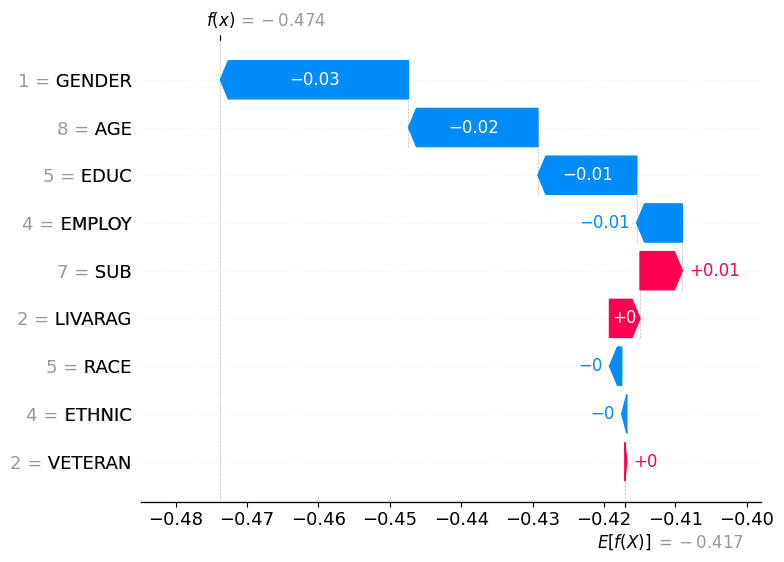

In [46]:
shap.waterfall_plot(shap_values[0])

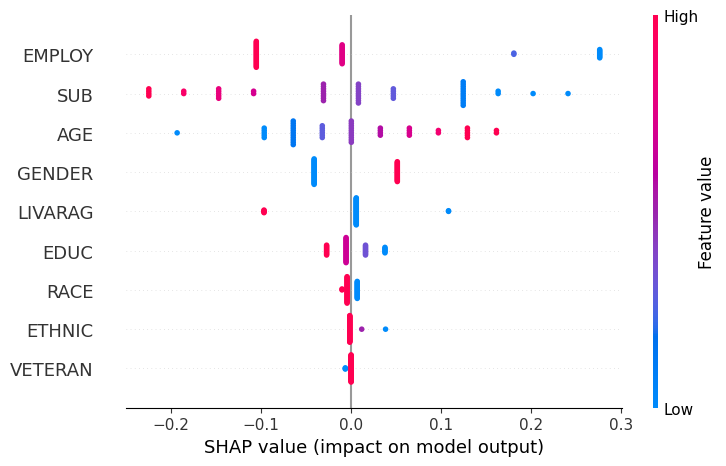

In [11]:
shap.plots.beeswarm(shap_values)

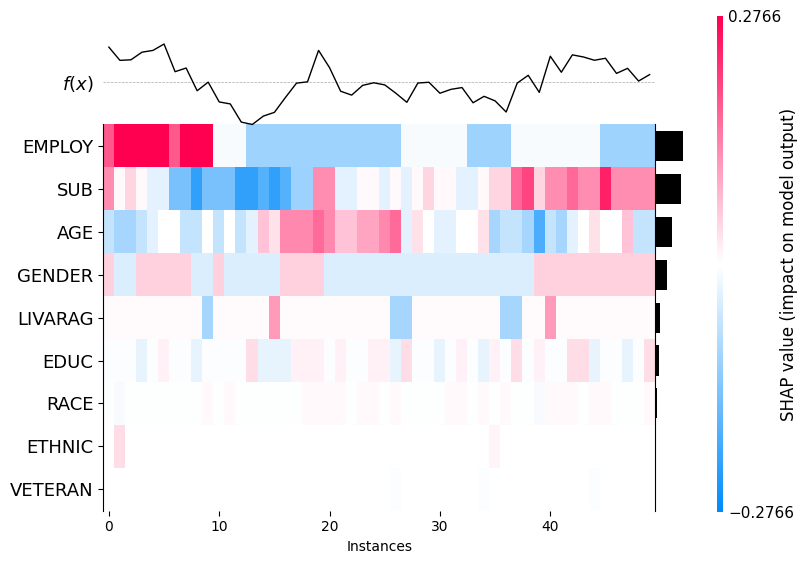

<Axes: xlabel='Instances'>

In [10]:
shap.plots.heatmap(shap_values[:1000])

# Unsupervised Models

In [18]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import pairwise_distances
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from sklearn.metrics import silhouette_samples

## Hierarchical Clustering

In [19]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [20]:
# Create a pipeline for Hierarchical Clustering
hierarchical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clustering', AgglomerativeClustering())
])

# Define the Optuna objective function for Hierarchical Clustering
def hierarchical_objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    linkage = trial.suggest_categorical('linkage', ['ward', 'complete', 'average', 'single'])

    # Update pipeline parameters
    hierarchical_pipeline.set_params(clustering__n_clusters=n_clusters, clustering__linkage=linkage)
    
    # Fit pipeline
    X_scaled = StandardScaler().fit_transform(X_resampled)  # Scaling outside for silhouette
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = model.fit_predict(X_scaled)
    
    return silhouette_score(X_scaled, labels)

In [21]:
# Perform Optuna optimization
study_hierarchical = optuna.create_study(direction='maximize')
study_hierarchical.optimize(hierarchical_objective, n_trials=50)

print("Best Parameters for Hierarchical Clustering:", study_hierarchical.best_params)

Best Parameters for Hierarchical Clustering: {'n_clusters': 2, 'linkage': 'single'}


In [31]:
# Fit and evaluate the best model
best_hierarchical = AgglomerativeClustering(
    n_clusters=study_hierarchical.best_params['n_clusters'], 
    linkage=study_hierarchical.best_params['linkage']
)
X_scaled = StandardScaler().fit_transform(X_resampled)
labels = best_hierarchical.fit_predict(X_scaled)
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(X_scaled, labels))

Silhouette Score for Hierarchical Clustering: 0.5047163365882567


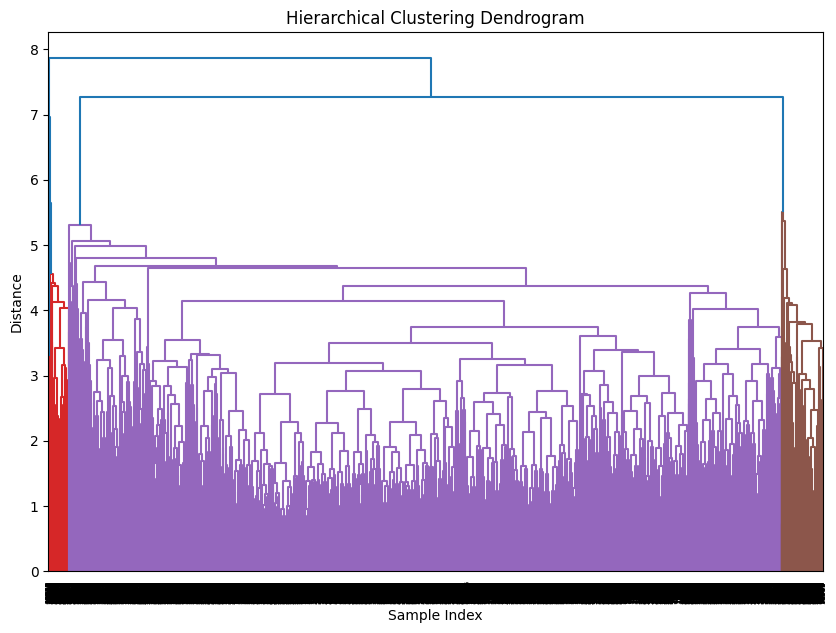

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Compute the linkage matrix
linkage_matrix = linkage(X_scaled, method=study_hierarchical.best_params['linkage'])

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, truncate_mode='level', p=25, show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

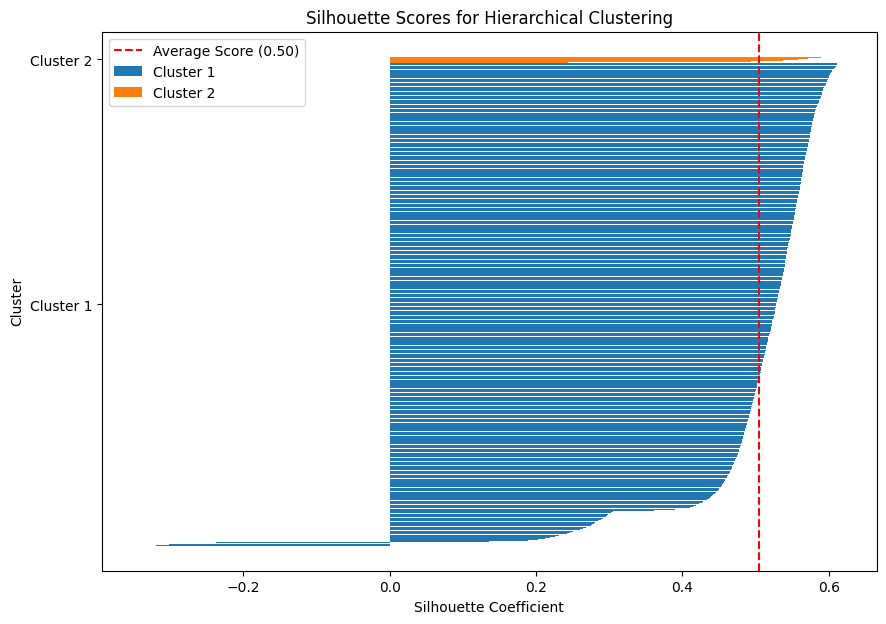

In [33]:
# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(X_scaled, labels)

# Plot silhouette scores
plt.figure(figsize=(10, 7))
y_ticks = []
y_lower = 0
for i in range(study_hierarchical.best_params['n_clusters']):
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    y_upper = y_lower + len(cluster_silhouette_vals)
    plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', label=f'Cluster {i + 1}')
    y_ticks.append((y_lower + y_upper) / 2)
    y_lower = y_upper

# Plot vertical line for the average silhouette score
avg_score = silhouette_score(X_scaled, labels)
plt.axvline(avg_score, color='red', linestyle='--', label=f'Average Score ({avg_score:.2f})')

plt.yticks(y_ticks, [f'Cluster {i + 1}' for i in range(study_hierarchical.best_params['n_clusters'])])
plt.xlabel('Silhouette Coefficient')
plt.ylabel('Cluster')
plt.title('Silhouette Scores for Hierarchical Clustering')
plt.legend(loc='best')
plt.show()

## K-Modes Clustering

In [34]:
# Define pipeline
kmodes_pipeline = Pipeline([
    ('clustering', KModes())
])

# Define Optuna objective function
def kmodes_objective(trial):
    # Hyperparameter suggestions
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    init = trial.suggest_categorical('init', ['Huang', 'Cao'])
    n_init = trial.suggest_int('n_init', 1, 10)

    # Update pipeline with suggested hyperparameters
    kmodes_pipeline.set_params(clustering__n_clusters=n_clusters, clustering__init=init, clustering__n_init=n_init)
    
    # Fit and predict labels
    labels = kmodes_pipeline.fit_predict(X_train)
    
    # Evaluate using silhouette score (Hamming metric for categorical data)
    score = silhouette_score(X_train, labels, metric='hamming')
    return score


In [35]:
# Run Optuna to optimize K-Modes Clustering
study_kmodes = optuna.create_study(direction='maximize')  # Maximize silhouette score
study_kmodes.optimize(kmodes_objective, n_trials=50)

# Best parameters
print("Best Parameters for K-Modes Clustering:")
print(study_kmodes.best_params)

Best Parameters for K-Modes Clustering:
{'n_clusters': 3, 'init': 'Huang', 'n_init': 4}


In [36]:
# Update pipeline with best parameters
kmodes_pipeline.set_params(
    clustering__n_clusters=study_kmodes.best_params['n_clusters'],
    clustering__init=study_kmodes.best_params['init'],
    clustering__n_init=study_kmodes.best_params['n_init']
)

# Train final model with best parameters
labels_best = kmodes_pipeline.fit_predict(X_train)

# Evaluate final model
silhouette_best = silhouette_score(X_train, labels_best, metric='hamming')
print(f"Silhouette Score for K-Modes Clustering: {silhouette_best}")

Silhouette Score for K-Modes Clustering: 0.06742707236220186


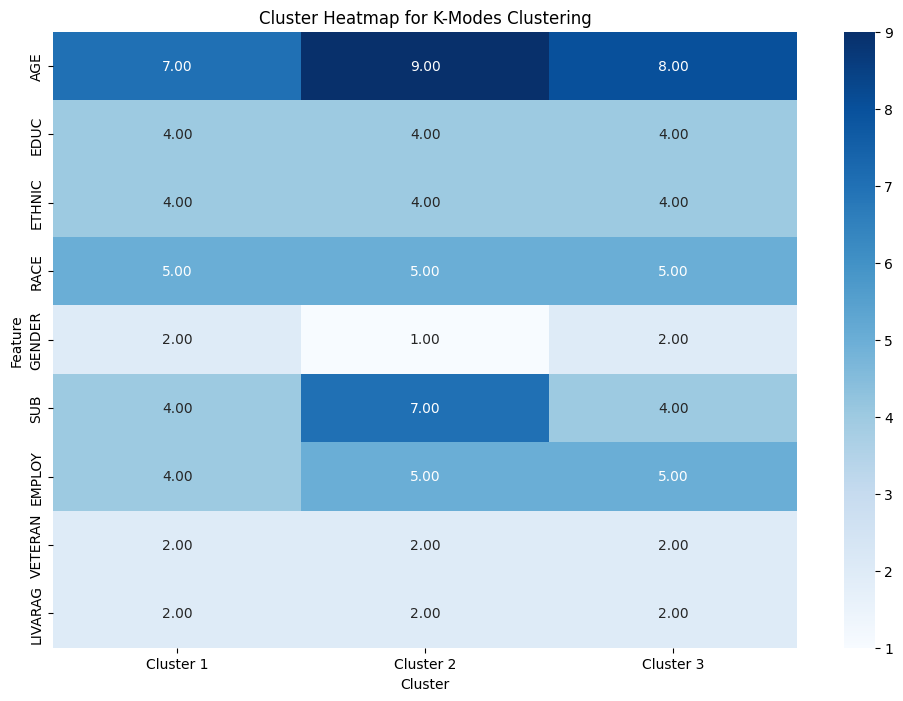

In [37]:
# Calculate the mean of each feature within each cluster
X_train_df = pd.DataFrame(X_train)  # Ensure X_train is a DataFrame for compatibility
cluster_centers = pd.DataFrame(
    kmodes_pipeline.named_steps['clustering'].cluster_centroids_,
    columns=X_train_df.columns
)
cluster_centers.index = [f'Cluster {i+1}' for i in range(cluster_centers.shape[0])]

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers.T, annot=True, fmt='.2f', cmap='Blues', cbar=True)
plt.title('Cluster Heatmap for K-Modes Clustering')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

## MCA

In [7]:
from prince import MCA

# Define the combined MCA and Logistic Regression objective
def mca_objective(trial):
    # Suggest the number of components for MCA
    n_components = trial.suggest_int('n_components', 2, min(X_train.shape[1], 10))
    
    # Suggest Logistic Regression hyperparameters
    C = trial.suggest_float('C', 0.01, 100, log=True)  # Regularization strength
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])  # Regularization type
    solver = trial.suggest_categorical('solver', ['saga', 'liblinear'])  # Solvers for l1 and l2

    # Ensure solver compatibility with penalty
    if penalty == 'l1' and solver == 'liblinear':
        solver = 'liblinear'
    elif penalty == 'l1':
        solver = 'saga'
    
    # Train the MCA model
    mca_model = MCA(n_components=n_components, random_state=42)
    mca_model = mca_model.fit(X_train)
    X_transformed = mca_model.row_coordinates(X_train)
    
    # Train Logistic Regression with cross-validation
    clf = LogisticRegression(C=C, penalty=penalty, solver=solver, class_weight='balanced', max_iter=1000, random_state=42)
    cv_scores = cross_val_score(clf, X_transformed, y_train, cv=5, scoring='accuracy')
    
    # Return the mean accuracy as the objective to maximize
    return cv_scores.mean()

In [8]:
# Optimize the number of components using the MCA objective
study_mca_lr = optuna.create_study(direction='maximize')
study_mca_lr.optimize(mca_objective, n_trials=50)

# Output the best parameters
print("Best Parameters for MCA and Logistic Regression:")
print(study_mca_lr.best_params)

[I 2024-12-02 17:16:46,819] A new study created in memory with name: no-name-58672f4b-fa38-4eb8-96e2-3835f850191c
[I 2024-12-02 17:16:47,035] Trial 0 finished with value: 0.5154284218183727 and parameters: {'n_components': 3, 'C': 15.225458955478548, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5154284218183727.
[I 2024-12-02 17:16:47,279] Trial 1 finished with value: 0.534706058026648 and parameters: {'n_components': 7, 'C': 2.917989325232422, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 1 with value: 0.534706058026648.
[I 2024-12-02 17:16:47,807] Trial 2 finished with value: 0.5285897933085263 and parameters: {'n_components': 6, 'C': 91.05266991822144, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.534706058026648.
[I 2024-12-02 17:16:48,318] Trial 3 finished with value: 0.5347606729911482 and parameters: {'n_components': 7, 'C': 15.135681643509653, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 3 with value: 0.534760672991148

Best Parameters for MCA and Logistic Regression:
{'n_components': 7, 'C': 15.135681643509653, 'penalty': 'l2', 'solver': 'saga'}


In [11]:
# Train Final MCA Model
best_params = study_mca_lr.best_params
best_n_components = best_params['n_components']
best_mca_model = MCA(n_components=best_n_components, random_state=42)
best_mca_model = best_mca_model.fit(X_train)

# Transform training and test data
X_train_transformed = best_mca_model.row_coordinates(X_train)
X_test_transformed = best_mca_model.row_coordinates(X_test)

# Train Logistic Regression with Best Parameters
best_clf = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)
best_clf.fit(X_train_transformed, y_train)
y_pred = best_clf.predict(X_test_transformed)

# Evaluate Final Model
accuracy = accuracy_score(y_test, y_pred)
print("Confusion Matrix for MCA Logistic Regression:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report for MCA Logistic Regression:")
print(classification_report(y_test, y_pred))
print(f"MCA Logistic Regression Accuracy on Test Set: {accuracy:.4f}")

Confusion Matrix for MCA Logistic Regression:
[[1448 1323]
 [ 837  970]]
Classification Report for MCA Logistic Regression:
              precision    recall  f1-score   support

           0       0.63      0.52      0.57      2771
           1       0.42      0.54      0.47      1807

    accuracy                           0.53      4578
   macro avg       0.53      0.53      0.52      4578
weighted avg       0.55      0.53      0.53      4578

MCA Logistic Regression Accuracy on Test Set: 0.5282


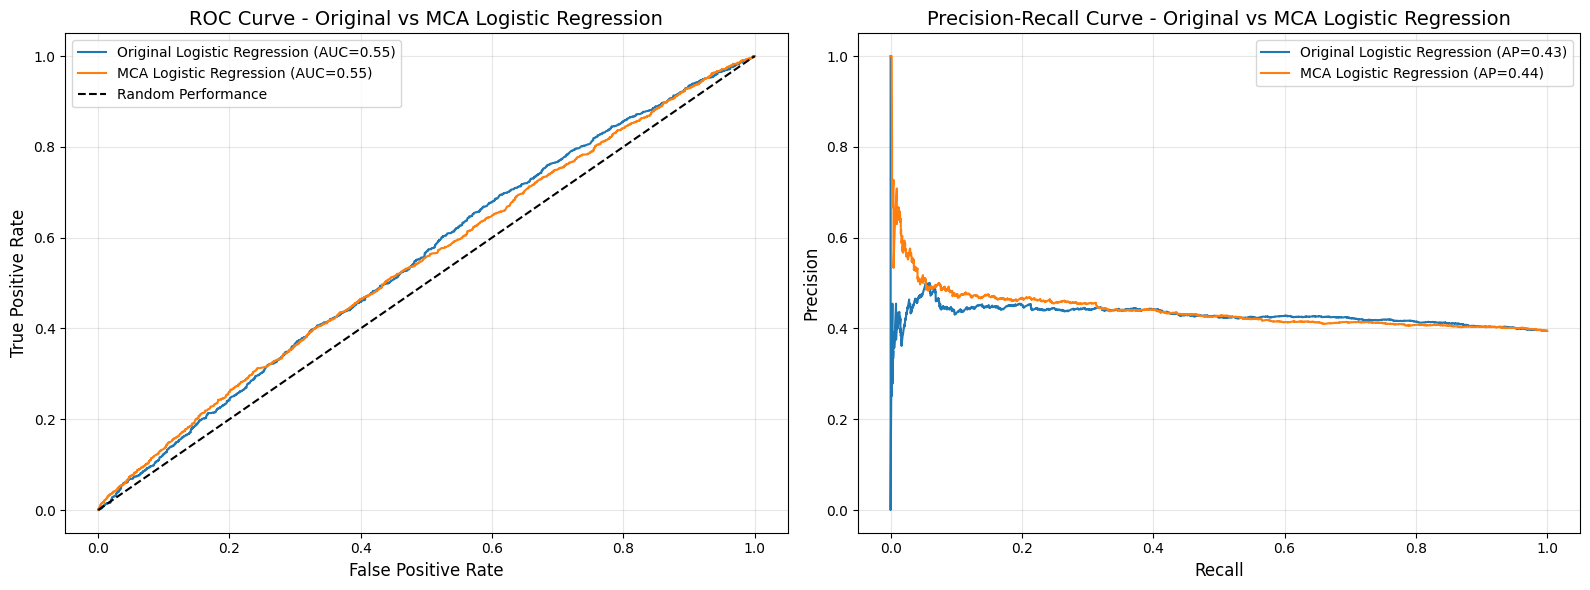

In [41]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Transform training and test data using the MCA model
X_train_transformed = best_mca_model.row_coordinates(X_train)
X_test_transformed = best_mca_model.row_coordinates(X_test)

# Train logistic regression model on transformed training data
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train_transformed, y_train)

# Get predicted probabilities for the test set
y_pred_proba = clf.predict_proba(X_test_transformed)[:, 1]

# Compute ROC Curve and AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Compute Precision-Recall Curve and Average Precision
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

# Create a 1x2 subplot for Original Logistic Regression and MCA Logistic Regression ROC and PRC
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve
axes[0].plot(fpr_lr, tpr_lr, label=f'Original Logistic Regression (AUC={roc_auc_lr:.2f})')
axes[0].plot(fpr, tpr, label=f'MCA Logistic Regression (AUC={roc_auc:.2f})')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random Performance')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Original vs MCA Logistic Regression', fontsize=14)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
axes[1].plot(recall_lr, precision_lr, label=f'Original Logistic Regression (AP={pr_auc_lr:.2f})')
axes[1].plot(recall, precision, label=f'MCA Logistic Regression (AP={average_precision:.2f})')
axes[1].set_xlabel('Recall', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Original vs MCA Logistic Regression', fontsize=14)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Silhouette Score for Hierarchical Clustering: 0.5047163365882567
Silhouette Score for Hierarchical Clustering with MCA: 0.5711104395655878


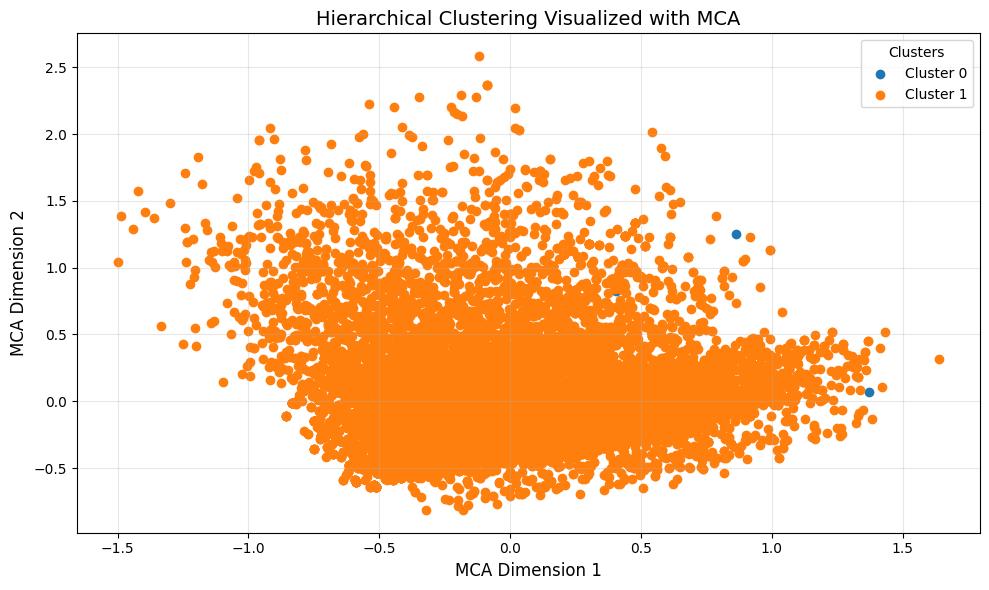

In [42]:
# Perform MCA for dimensionality reduction to 2D
mca = MCA(n_components=best_n_components, random_state=42)
X_mca = mca.fit_transform(X_train)  # Reduce the data to 2D using MCA

# Fit Agglomerative Clustering on the MCA-transformed data
hc_model = AgglomerativeClustering(n_clusters=study_hierarchical.best_params['n_clusters'], 
                                    linkage=study_hierarchical.best_params['linkage'])
hc_labels = hc_model.fit_predict(X_mca)

# Calculate silhouette score for hierarchical clustering on MCA-transformed data
silhouette_avg = silhouette_score(X_mca, hc_labels)

# Print original silhouette score
best_hierarchical = AgglomerativeClustering(
    n_clusters=study_hierarchical.best_params['n_clusters'], 
    linkage=study_hierarchical.best_params['linkage']
)
X_scaled = StandardScaler().fit_transform(X_resampled)
labels = best_hierarchical.fit_predict(X_scaled)
print("Silhouette Score for Hierarchical Clustering:", silhouette_score(X_scaled, labels))

# Print MCA silhouette score
print(f"Silhouette Score for Hierarchical Clustering with MCA: {silhouette_avg}")

# Create a scatter plot for the clusters
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(hc_labels)
for cluster in unique_clusters:
    cluster_points = X_mca[hc_labels == cluster]
    plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster}')

# Add plot details
plt.title('Hierarchical Clustering Visualized with MCA', fontsize=14)
plt.xlabel('MCA Dimension 1', fontsize=12)
plt.ylabel('MCA Dimension 2', fontsize=12)
plt.legend(title='Clusters', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Silhouette Score for K-Modes Clustering: 0.10281805950290665
Silhouette Score for K-Modes Clustering with MCA: 0.02122415477475587


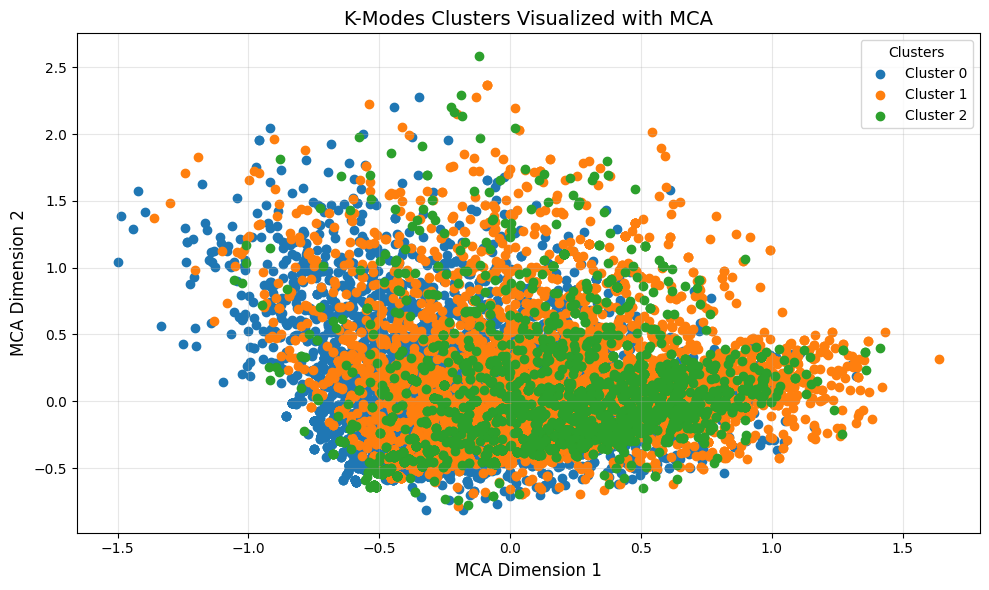

In [43]:
# Extract cluster labels from the fitted K-Modes model
cluster_labels = kmodes_pipeline.named_steps['clustering'].labels_

# Print original silhouette score for K-Modes clustering
labels_best = kmodes_pipeline.fit_predict(X_train)
silhouette_best = silhouette_score(X_train, labels_best, metric='hamming')
print(f"Silhouette Score for K-Modes Clustering: {silhouette_best}")

# Print silhouette score for K-Modes clustering on MCA-transformed data
silhouette_avg_kmodes = silhouette_score(X_mca, cluster_labels)
print(f"Silhouette Score for K-Modes Clustering with MCA: {silhouette_avg_kmodes}")

# Create a scatter plot for the clusters
plt.figure(figsize=(10, 6))
unique_clusters = np.unique(cluster_labels)
for cluster in unique_clusters:
    cluster_points = X_mca[cluster_labels == cluster]
    plt.scatter(cluster_points.iloc[:, 0], cluster_points.iloc[:, 1], label=f'Cluster {cluster}')

# Add plot details
plt.title('K-Modes Clusters Visualized with MCA', fontsize=14)
plt.xlabel('MCA Dimension 1', fontsize=12)
plt.ylabel('MCA Dimension 2', fontsize=12)
plt.legend(title='Clusters', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()